In [1]:
import time
import random
import matplotlib.pyplot as plt 
import matplotlib.patches as patches
import uuid

In [2]:
#reference: https://jrtechs.net/data-science/implementing-a-quadtree-in-python

## Node class

In [3]:
# Node class is a rectangle in the quardtree
# with (x0, y0) as coordinates, w as width, h as height
class Node():
    def __init__(self, x0, y0, w, h):
        self.x0 = x0
        self.y0 = y0
        self.width = w
        self.height = h
        self.children = []
        # the unique id for each node
        self.id = uuid.uuid4().hex[:4]

    def get_location(self):
        return (self.x0, self.yo)
    
    def get_width(self):
        return self.width
    
    def get_height(self):
        return self.height
    
    def get_children(self):
        return self.children

## QTree class

In [4]:
# QTree class which can do the divide and graph of quardtree
class QTree():
    def __init__(self):
        self.root = Node(0, 0, 10, 10)
        
    def subdivide(self, node):
        w_ = float(node.width/2)
        h_ = float(node.height/2)
        x1 = Node(node.x0, node.y0, w_, h_)
        x2 = Node(node.x0, node.y0+h_, w_, h_)
        x3 = Node(node.x0 + w_, node.y0, w_, h_)
        x4 = Node(node.x0+w_, node.y0+h_, w_, h_)
        node.children = [x1, x2, x3, x4]
        
    def weld(self, node):
        node.children = []
        
    def graph(self):
        fig, ax = plt.subplots(figsize=(8, 8))
        plt.title("Quadtree")
        ax.set_xlim(0, 10)
        ax.set_ylim(0, 10)
        c = find_children(self.root)
        print("Number of segments: %d" %len(c))
        areas = set()
        for el in c:
            areas.add(el.width*el.height)
        print("Minimum segment area: %.3f units" %min(areas))
        for n in c:
            #print((n.x0, n.y0), n.width, n.height)
            rect = patches.Rectangle((n.x0, n.y0), n.width, n.height, fill=False)
            ax.add_patch(rect)
        patches_list = ax.patches
        plt.show()

## Essential methods about finding children and parents, the size distribution and plotting

### Method about find the children and parents

In [5]:
# FIND the list of all nodes that can be divide(the leaf)
def find_children(node):
    if not node.children:
        return [node]
    else:
        children = []
        for child in node.children:
            children +=(find_children(child))
    return children

# FIND the list of all nodes that can be fuse(the parent)
def find_parents(node):
    if len(node.children) != 4:
        return []
    else: 
        parent = [node]
        for child in node.children:
            parent += find_parents(child)
        return parent


### Method about find the size distribution and plotting

In [6]:
# FIND the dictionary of leave nodes' size(sorted)
from collections import OrderedDict      # ordered dictionary is used for sorted the size

def find_size(node):
    if not node.children:
        size = node.width * node.height
        return {size: 1}
    else:
        sizes = {}
        for child in node.children:
            child_sizes = find_size(child)
            for child_size, count in child_sizes.items():
                if child_size in sizes:
                    sizes[child_size] += count
                else:
                    sizes[child_size] = count
        sorted_sizes = OrderedDict(sorted(sizes.items()))
        return sorted_sizes

# plot the size distribution
def plot_size_distribution(size_distribution):
    sizes = list(size_distribution.keys())
    counts = list(size_distribution.values())

    plt.bar(sizes, counts)
    plt.xlabel('Node Size')
    plt.ylabel('Count')
    plt.title('Size Distribution of ice floes')
    plt.show()

## Visualization (not required)

In [7]:
# sudo apt install -y graphviz
# pip3 install graphviz
from graphviz import Graph, Digraph

In [8]:
# FIND the dictionary of all nodes id that can be divide(the leaf)
def find_children_id(node):
    if not node.children:
        return [node.id]
    else:
        children = []
        for child in node.children:
            children +=(find_children_id(child))
    return children

# FIND the dictionary of all nodes id that can be fuse(the parent)
def find_parents_id(node):
    if len(node.children) != 4:
        return []
    else: 
        parent = [node.id]
        for child in node.children:
            parent += find_parents_id(child)
        return parent

In [9]:
# draw the nodes in a tree graph
def tree_graph(node, g):
    if node.children == []:
        return g
    for child in node.children:
        g.edge(node.id, child.id)
        tree_graph(child, g)
    return g

## Example

Number of segments: 34
Minimum segment area: 0.024 units


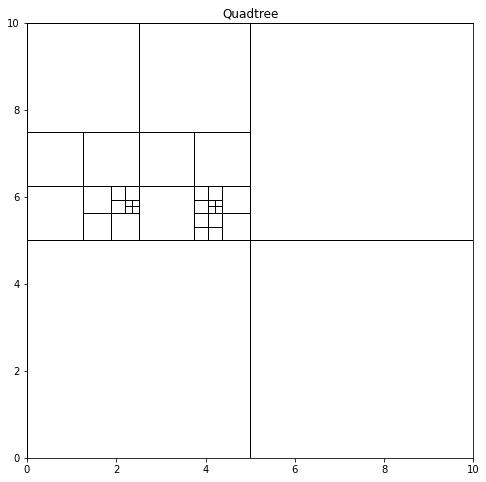

In [10]:
import random
# example of using QTreee 
quard = QTree()

# Divide random times between 0 and 5
for i in range(random.randint(0, 20)):
    # Divide random parent node
    index = random.randint(0,len(find_children(quard.root))-1)
    #print("Divide: ", find_children(quard.root)[index].id)
    quard.subdivide(find_children(quard.root)[index])

# Weld random times between 0 and 5
for i in range(random.randint(0, 10)):
    # Weld random child node to a parent node
    if len(find_parents(quard.root)) == 0:
        break
    if len(find_parents(quard.root)) == 1:
        #print("Weld the children of: ", find_parents(quard.root)[0].id)
        quard.weld(find_parents(quard.root)[0])
        break
    index = random.randint(0,len(find_parents(quard.root))-1)
    #print("Weld the children of: ", find_parents(quard.root)[index].id)
    quard.weld(find_parents(quard.root)[index])
quard.graph() 

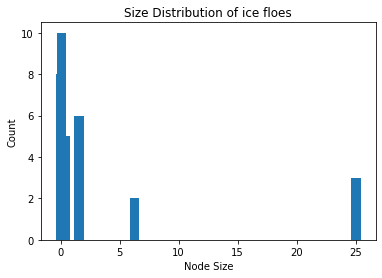

In [11]:
# the size distribution of the tree
size_distribution = find_size(quard.root)
plot_size_distribution(size_distribution)

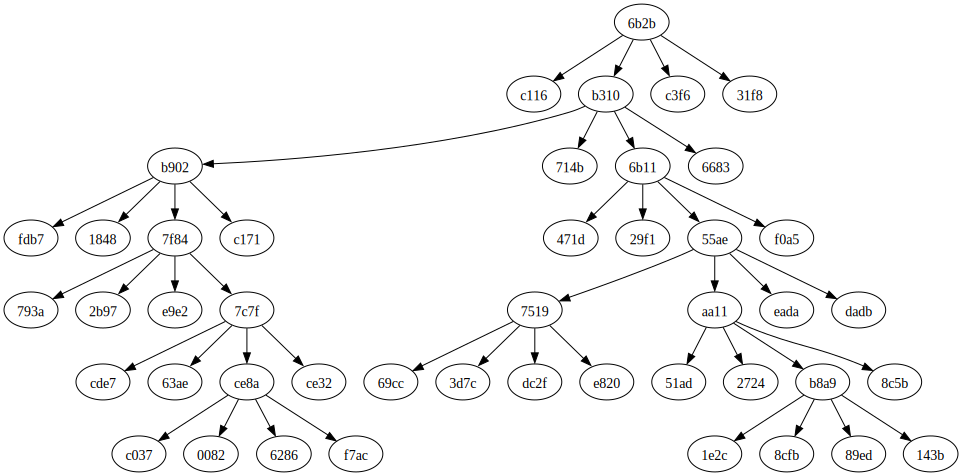

In [12]:
g = Digraph()
tree_graph(quard.root, g)

In [13]:
t = 0
N = 1
for i in range(1,10):
    t+= random.expovariate(15)
    print (N, t)

1 0.00010166960921026366
1 0.13390901452657994
1 0.21208474495773022
1 0.2175797549051884
1 0.22418776464262816
1 0.2671660822370792
1 0.353350251424514
1 0.35758364810831983
1 0.3658137425814169


## Simulation

### A simple random choice based on probability of divide, weld rate

In [14]:
class Python_Switch:
    def behave(self, num, quard):
        default = "Error input: input should be integer from 0 to 2"
        self.quard = quard
        return getattr(self, 'case_' + str(num), lambda: default)()
    
    def case_0(self):
        # nothing happen
        return 

    def case_1(self):
        # divde
        index = random.randint(0,len(find_children(quard.root))-1)
        self.quard.subdivide(find_children(quard.root)[index])

    
    def case_2(self):
        if len(find_parents(quard.root)) == 1 or len(find_parents(quard.root)) == 0:
            return
        # weld
        index = random.randint(0,len(find_parents(quard.root))-1)
        self.quard.weld(find_parents(quard.root)[index])

In [15]:
# 0: nothing happen
# 1: fracture
# 2: weld
population = [0,1,2]
weights = [0.40724, 0.397583, 0.195177]

In [16]:
for i in range(1000000):
    num = random.choices(population, weights)[0]
    switch = Python_Switch()
    switch.behave(num, quard)

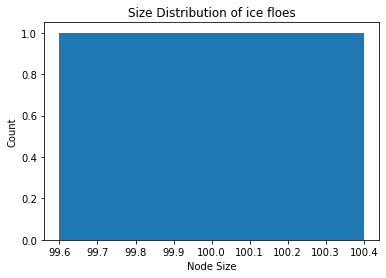

In [17]:
size_distribution = find_size(quard.root)
plot_size_distribution(size_distribution)

Number of segments: 1
Minimum segment area: 100.000 units


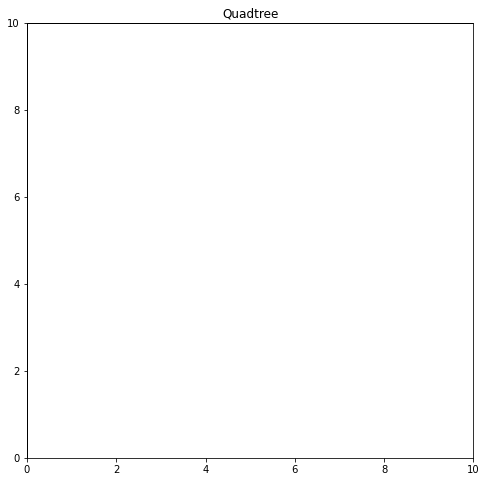

In [18]:
quard.graph() 

### Add layer to different sizes of ice floe

In [26]:
# Larger blocks more likely divide, smaller blocks more likely weld
class Python_Switch_Layer:
    def behave(self, num, quard):
        default = "Error input: input should be integer from 0 to 2"
        self.quard = quard
        return getattr(self, 'case_' + str(num), lambda: default)()
    
    def case_0(self):
        # nothing happen
        return 

    def case_1(self):
        # divde
        children = find_children(quard.root)
        weights1 = [i.width*i.height for i in children]
        self.quard.subdivide(random.choices(children, weights1)[0])

    
    def case_2(self):
        if len(find_parents(quard.root)) == 1 or len(find_parents(quard.root)) == 0:
            return
        # weld
        parents = find_parents(quard.root)
        weights2 = [1/(i.width*i.height) for i in parents]
        self.quard.weld(random.choices(parents, weights2)[0])

In [27]:
population = [0,1,2]
weights = [0.40724, 0.397583, 0.195177]
for i in range(1000):
    num = random.choices(population, weights)[0]
    switch = Python_Switch_Layer()
    switch.behave(num, quard)

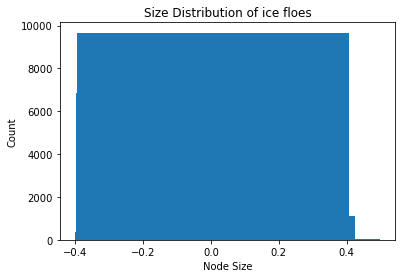

In [28]:
size_distribution = find_size(quard.root)
plot_size_distribution(size_distribution)

Number of segments: 18067
Minimum segment area: 0.000 units


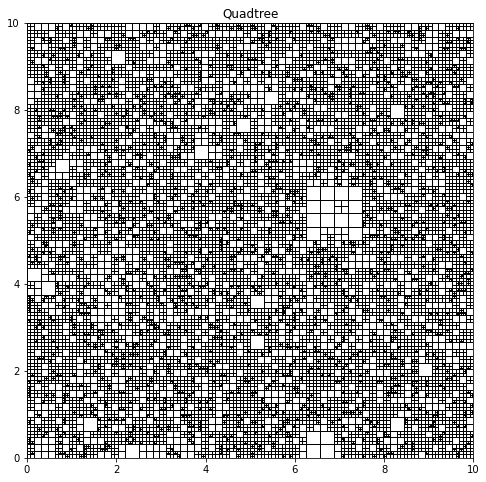

In [29]:
quard.graph()